In [1]:
from pyib.ml.models import *
import torch
from pyib.ml.train_utils import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pyib.md.utils import TrajectoryReader
from scipy.special import logsumexp
import matplotlib as mpl

In [2]:
DATA_PATH = "../data/T300_1mics/catch_bond/f_0/traj.dat"
NUM_LABELS = 10
LABEL_PATH= "../data/T300_1mics/catch_bond/labels/catch_bond_labels{}.npy".format(NUM_LABELS)

In [3]:
traj = TrajectoryReader(DATA_PATH)
time, data = traj.read_traj()
data = (data[:,:2] - data[:,:2].mean(axis=0))/data[:,:2].std(axis=0)

# Make temporary labels

In [9]:
minY = data[:,0].min() - 1e-3
maxY = data[:,0].max() + 1e-3

range_ = np.linspace(minY, maxY,NUM_LABELS+1)
digitized = np.digitize(data[:,0],range_)-1
np.save(LABEL_PATH,digitized)
labels = np.load(LABEL_PATH)

(-2.0, 2.0)

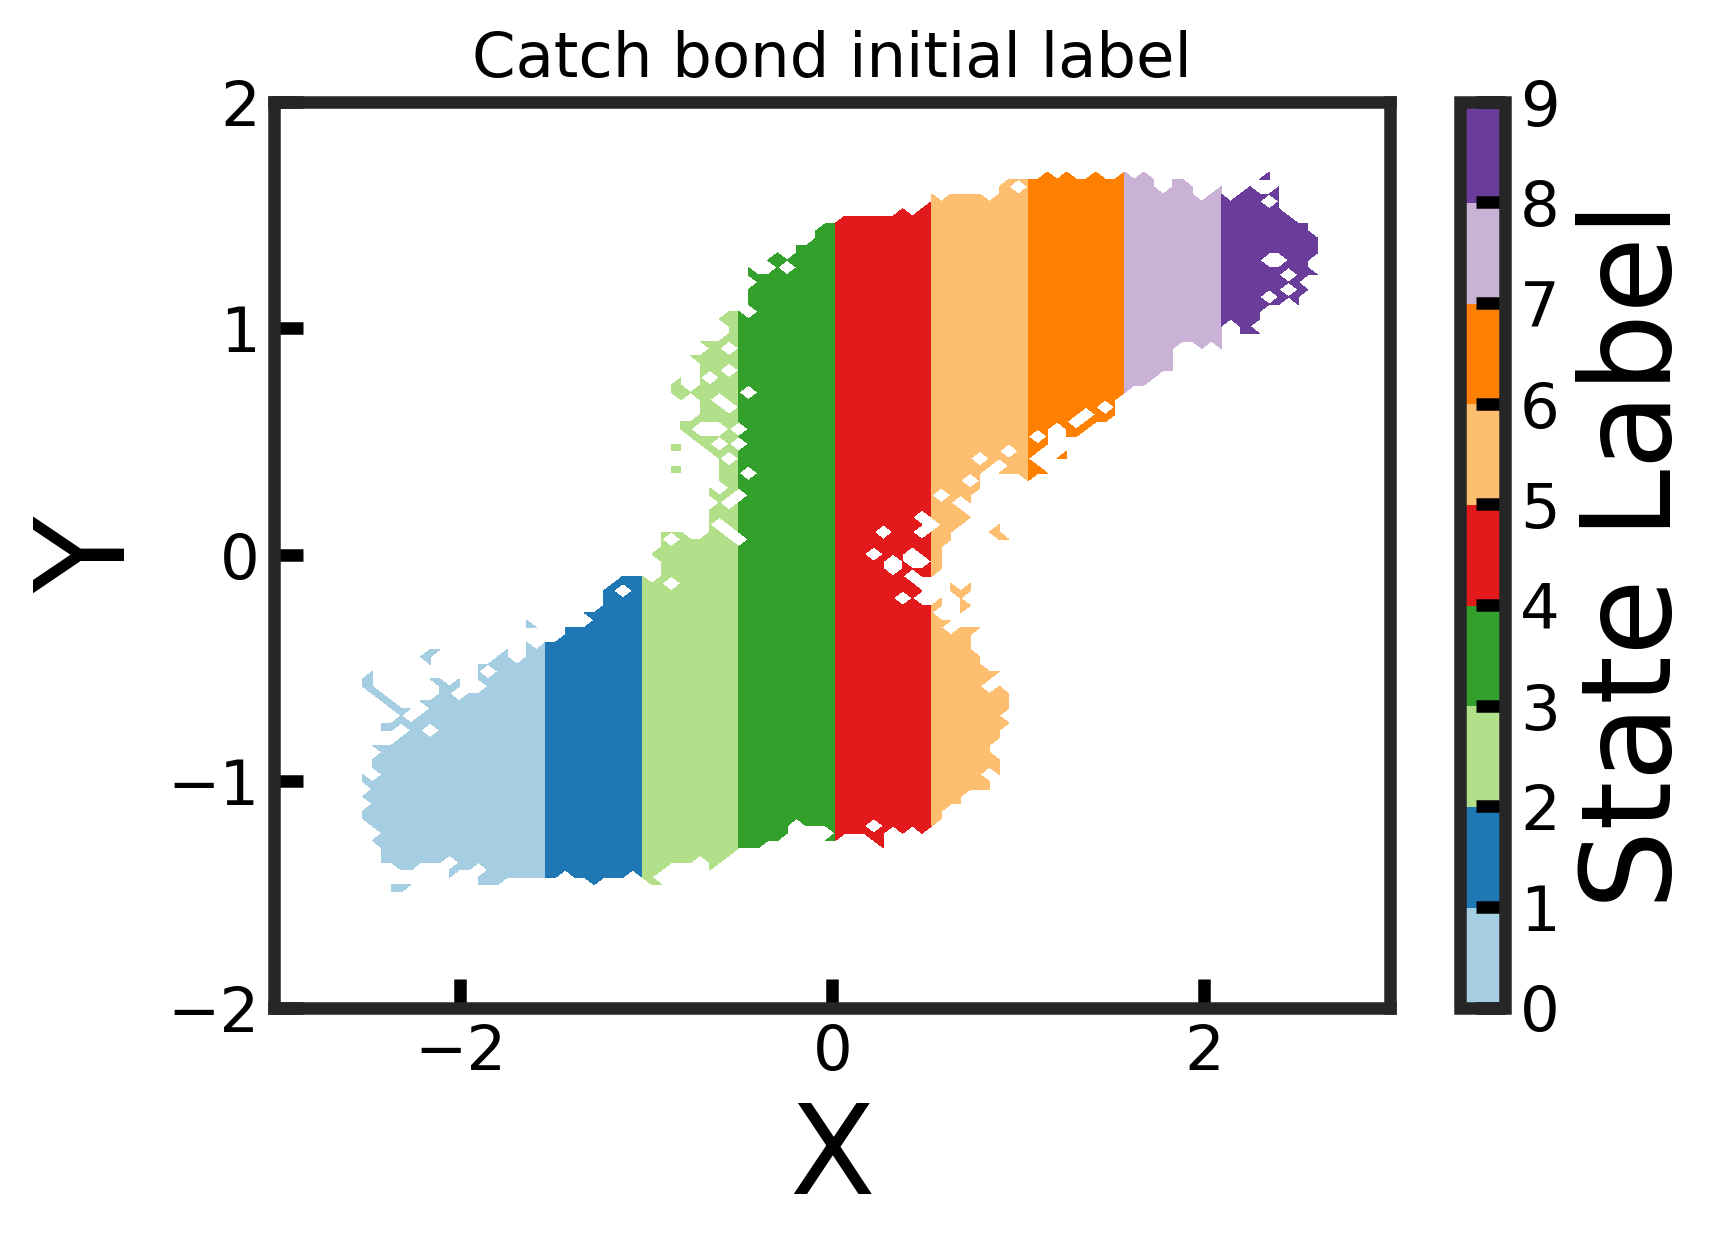

In [10]:
one_hot = np.zeros((labels.shape[0],NUM_LABELS))
vec = np.arange(one_hot.shape[0])
one_hot[vec, labels] = 1

BINS = 100
histogram,x,y = np.histogram2d(data[:,0],data[:,1],bins=BINS)

hist = np.zeros((NUM_LABELS,BINS,BINS))
for i in range(NUM_LABELS):
    hist[i] = np.histogram2d(data[:,0],data[:,1],bins=[x,y],weights=one_hot[:,i])[0]
initialLab = np.argmax(hist, axis=0).astype(float)
initialLab[histogram==0] = np.nan

ax = plt.figure(dpi=300).add_subplot(111)
levels = np.arange(10)
cMap = mpl.colors.ListedColormap(plt.cm.Paired.colors[0:10])
p  = ax.contourf(x[:-1],y[:-1],initialLab.T,cmap=cMap,levels=levels)
cbar = plt.colorbar(p)
cbar.set_label("State Label")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Catch bond initial label")
ax.set_xlim(-3,3)
ax.set_ylim(-2,2)

<ipython-input-11-6e478db92d59>:14: RuntimeWarning: divide by zero encountered in log
  FE = -np.log(hist)


Text(0, 0.5, 'Y')

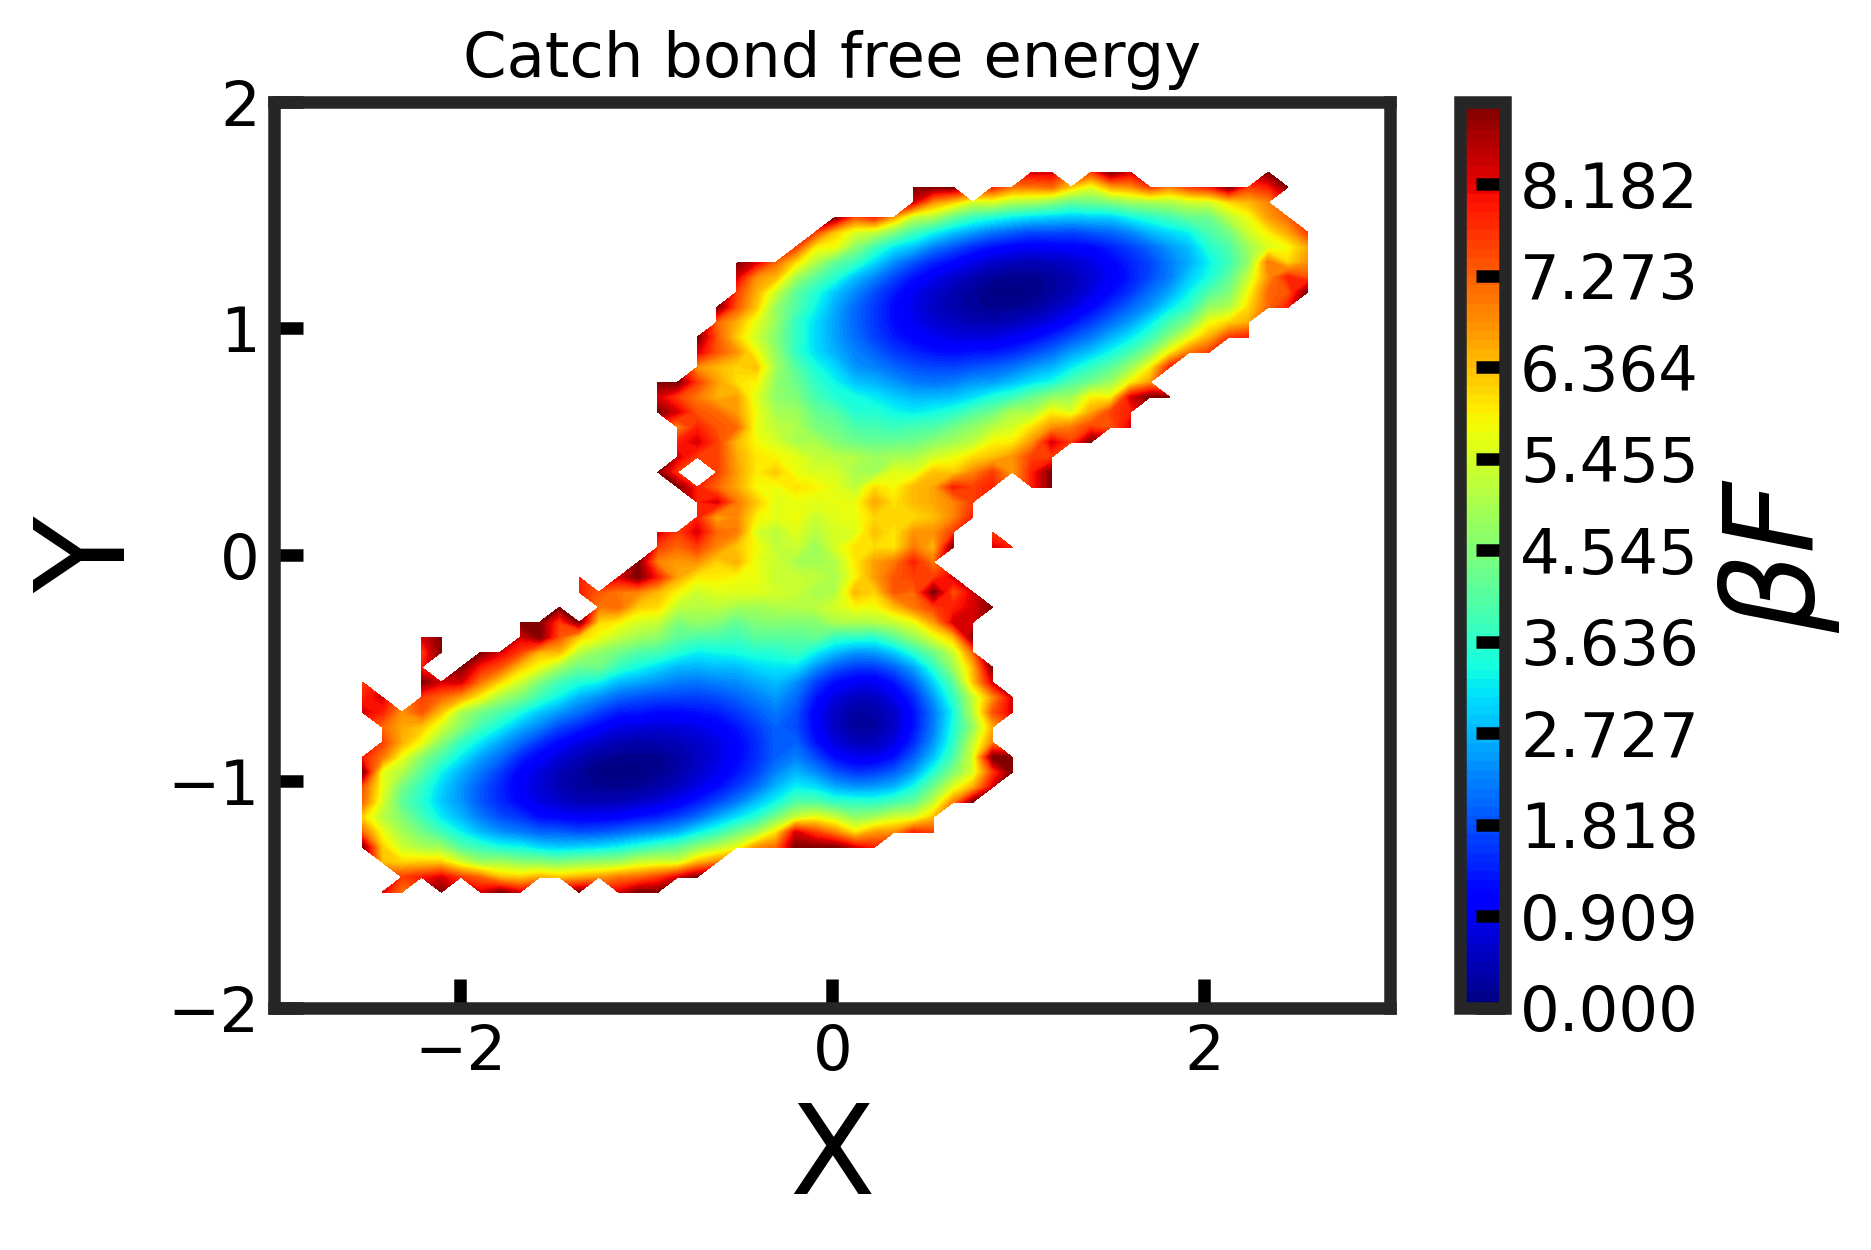

In [11]:
min_ = data.min(axis=0) - 1e-3
max_ = data.max(axis=0) + 1e-3

x = np.linspace(min_[0], max_[0])
y = np.linspace(min_[1], max_[1])

diff = np.array([x[1]-x[0], y[1]-y[0]])
w = (data - min_)/diff
w = w.astype(int)


hist,_,_ = np.histogram2d(data[:,0],data[:,1],(x,y))
hist = hist/hist.sum()
FE = -np.log(hist)
min_ = FE[~np.isnan(FE)].min()
FE -= min_

levels = np.linspace(0,9,100)
weights = FE[w[:,0],w[:,1]]

ax = plt.figure(dpi=300).add_subplot(111)
c = ax.contourf(x[:-1],y[:-1],FE.T,levels=levels,cmap='jet')
cbar = plt.colorbar(c)
cbar.set_label(r"$\beta F$")
ax.set_xlim(-3,3)
ax.set_ylim(-2,2)
ax.set_title("Catch bond free energy")
ax.set_xlabel("X")
ax.set_ylabel("Y")

### Initialize VAE

In [14]:
# Dimensions
INPUT_DIM  = 2
OUTPUT_DIM = NUM_LABELS
NEURON_DIM = 16
HIDDEN_DIM = 1

# Specify specific VAE parameters
encoder_dim = [INPUT_DIM, NEURON_DIM, NEURON_DIM]
hidden_dim = HIDDEN_DIM
decoder_dim = [NEURON_DIM, NEURON_DIM, OUTPUT_DIM]
restrictLogVar = False

# Specify VAE model
device = "cuda" if torch.cuda.is_available() else "cpu"
v =VAE(encoder_dim, hidden_dim, decoder_dim, activation=nn.ReLU(),device=device, restrictLogVar=restrictLogVar)

In [15]:
lagTime = 350
SPIB_train(v, DATA_PATH, LABEL_PATH, \
            lagTime, epochs=10, print_every=1,beta=0.01, \
            update_labels=True,batch_size=1024, one_hot=False, threshold=0.01, patience=2)

-----------------------------------
At Epoch 1
Average epoch Loss = 1.50407
Average KL loss = 0.99136
Average CE loss = 1.49416
Average test Loss = 1.39545
State population =  tensor([0.0000, 0.0000, 0.4004, 0.0068, 0.0000, 0.1740, 0.4188, 0.0000, 0.0000,
        0.0000])
State population change = 1.16289
-----------------------------------
At Epoch 2
Average epoch Loss = 1.39139
Average KL loss = 0.93974
Average CE loss = 1.38199
Average test Loss = 1.39195
State population =  tensor([0.0000, 0.0000, 0.4011, 0.0087, 0.0000, 0.1709, 0.4192, 0.0000, 0.0000,
        0.0000])
State population change = 0.00370
-----------------------------------
At Epoch 3
Average epoch Loss = 1.38876
Average KL loss = 0.75917
Average CE loss = 1.38117
Average test Loss = 1.38971
State population =  tensor([0.0000, 0.0000, 0.4099, 0.0022, 0.0000, 0.1686, 0.4193, 0.0000, 0.0000,
        0.0000])
State population change = 0.01123
-----------------------------------
At Epoch 4
Average epoch Loss = 1.38752
Ave

(-2.0, 2.0)

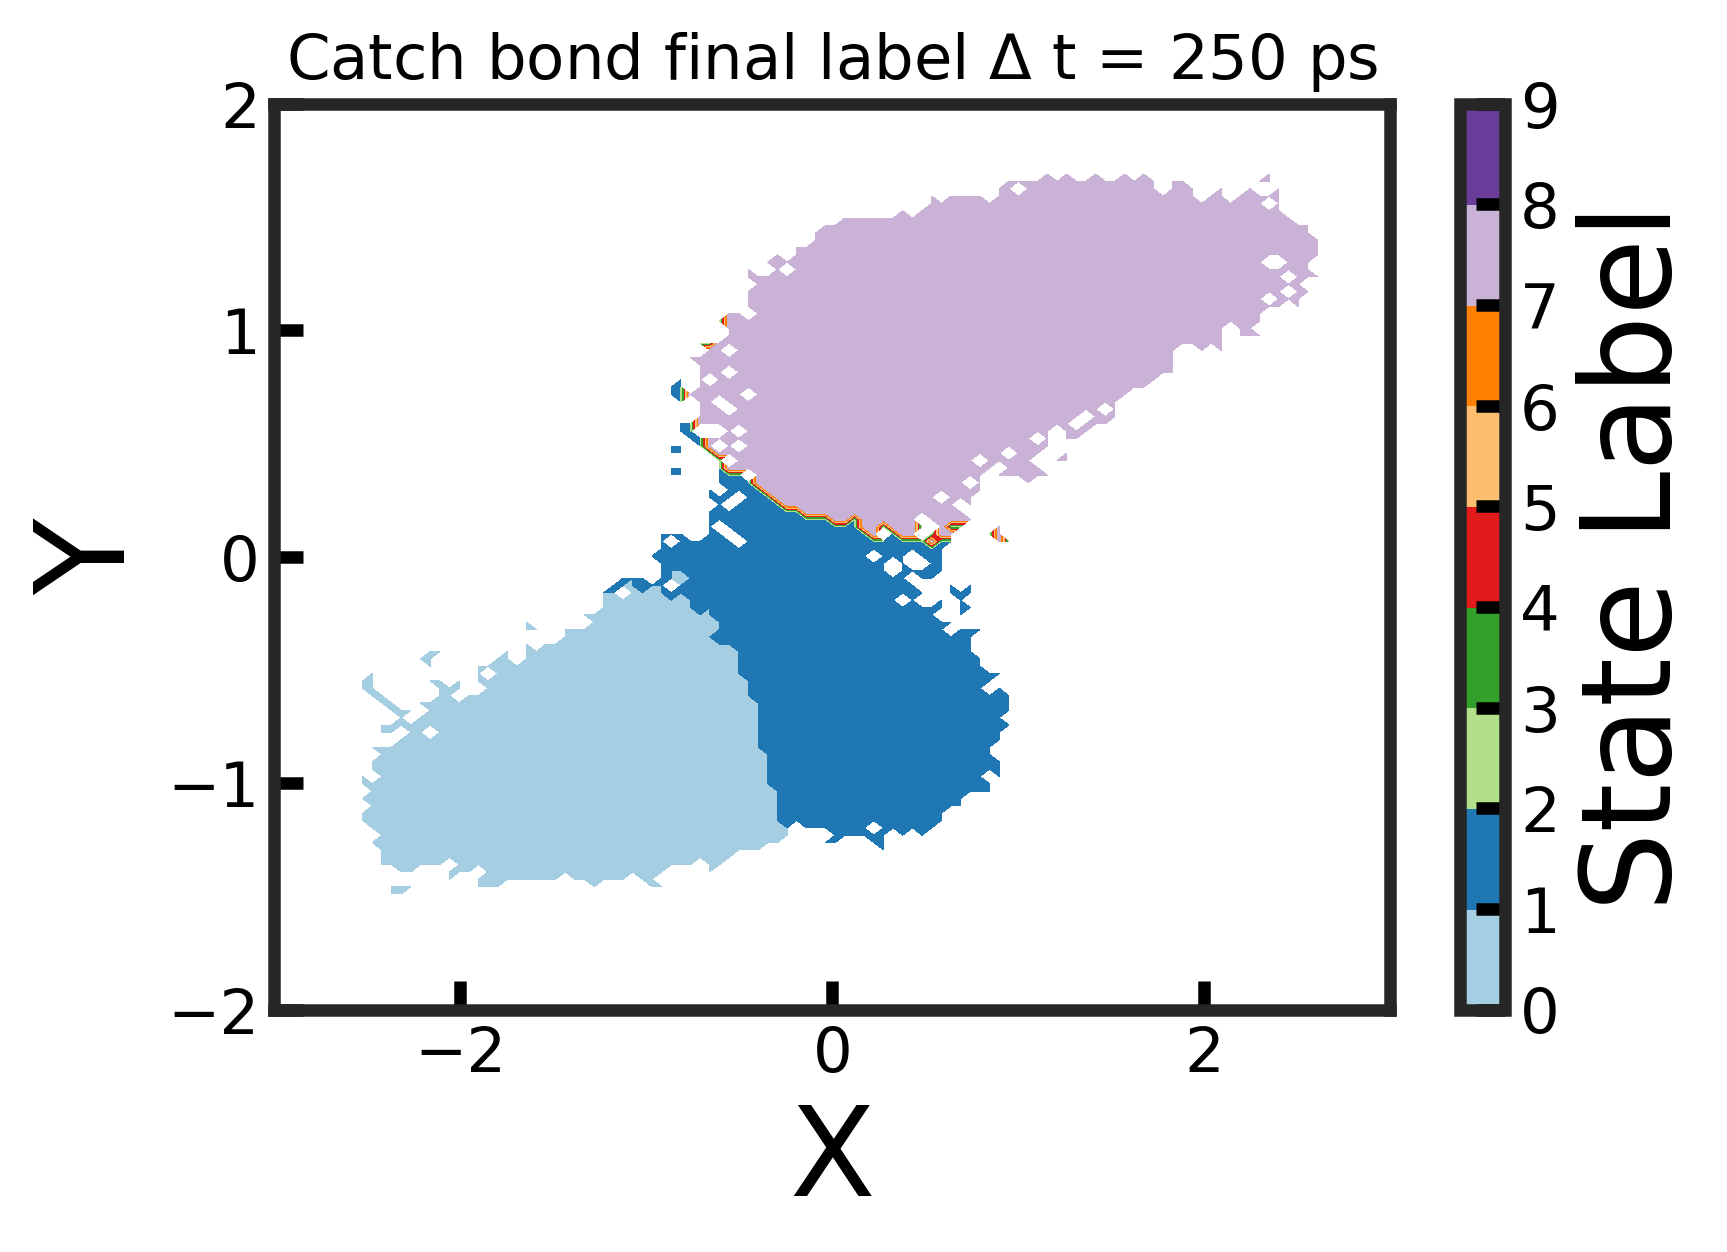

In [14]:
d = torch.tensor(data[:,:2], dtype=torch.float32)
l,mean,_,_ = v.evaluate(d)

one_hot = np.zeros((l.shape[0],NUM_LABELS))
vec = np.arange(one_hot.shape[0])
one_hot[vec, l.flatten()] = 1

BINS = 100
histogram,x,y = np.histogram2d(data[:,0],data[:,1],bins=BINS)

hist = np.zeros((NUM_LABELS,BINS,BINS))
for i in range(NUM_LABELS):
    hist[i] = np.histogram2d(data[:,0],data[:,1],bins=[x,y],weights=one_hot[:,i])[0]
initialLab = np.argmax(hist, axis=0).astype(float)
initialLab[histogram==0] = np.nan

ax = plt.figure(dpi=300).add_subplot(111)
levels = np.arange(10)
cMap = mpl.colors.ListedColormap(plt.cm.Paired.colors[0:10])
p  = ax.contourf(x[:-1],y[:-1],initialLab.T,cmap=cMap,levels=levels)
cbar = plt.colorbar(p)
cbar.set_label("State Label")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Catch bond final label $\Delta$ t = {} ps".format(lagTime))
ax.set_xlim(-3,3)
ax.set_ylim(-2,2)

<ipython-input-15-709f580e48e3>:3: RuntimeWarning: invalid value encountered in true_divide
  histRC = histMean/histdata


Text(0.5, 1.0, 'Catch bond $\\Delta$ t = 250 ps')

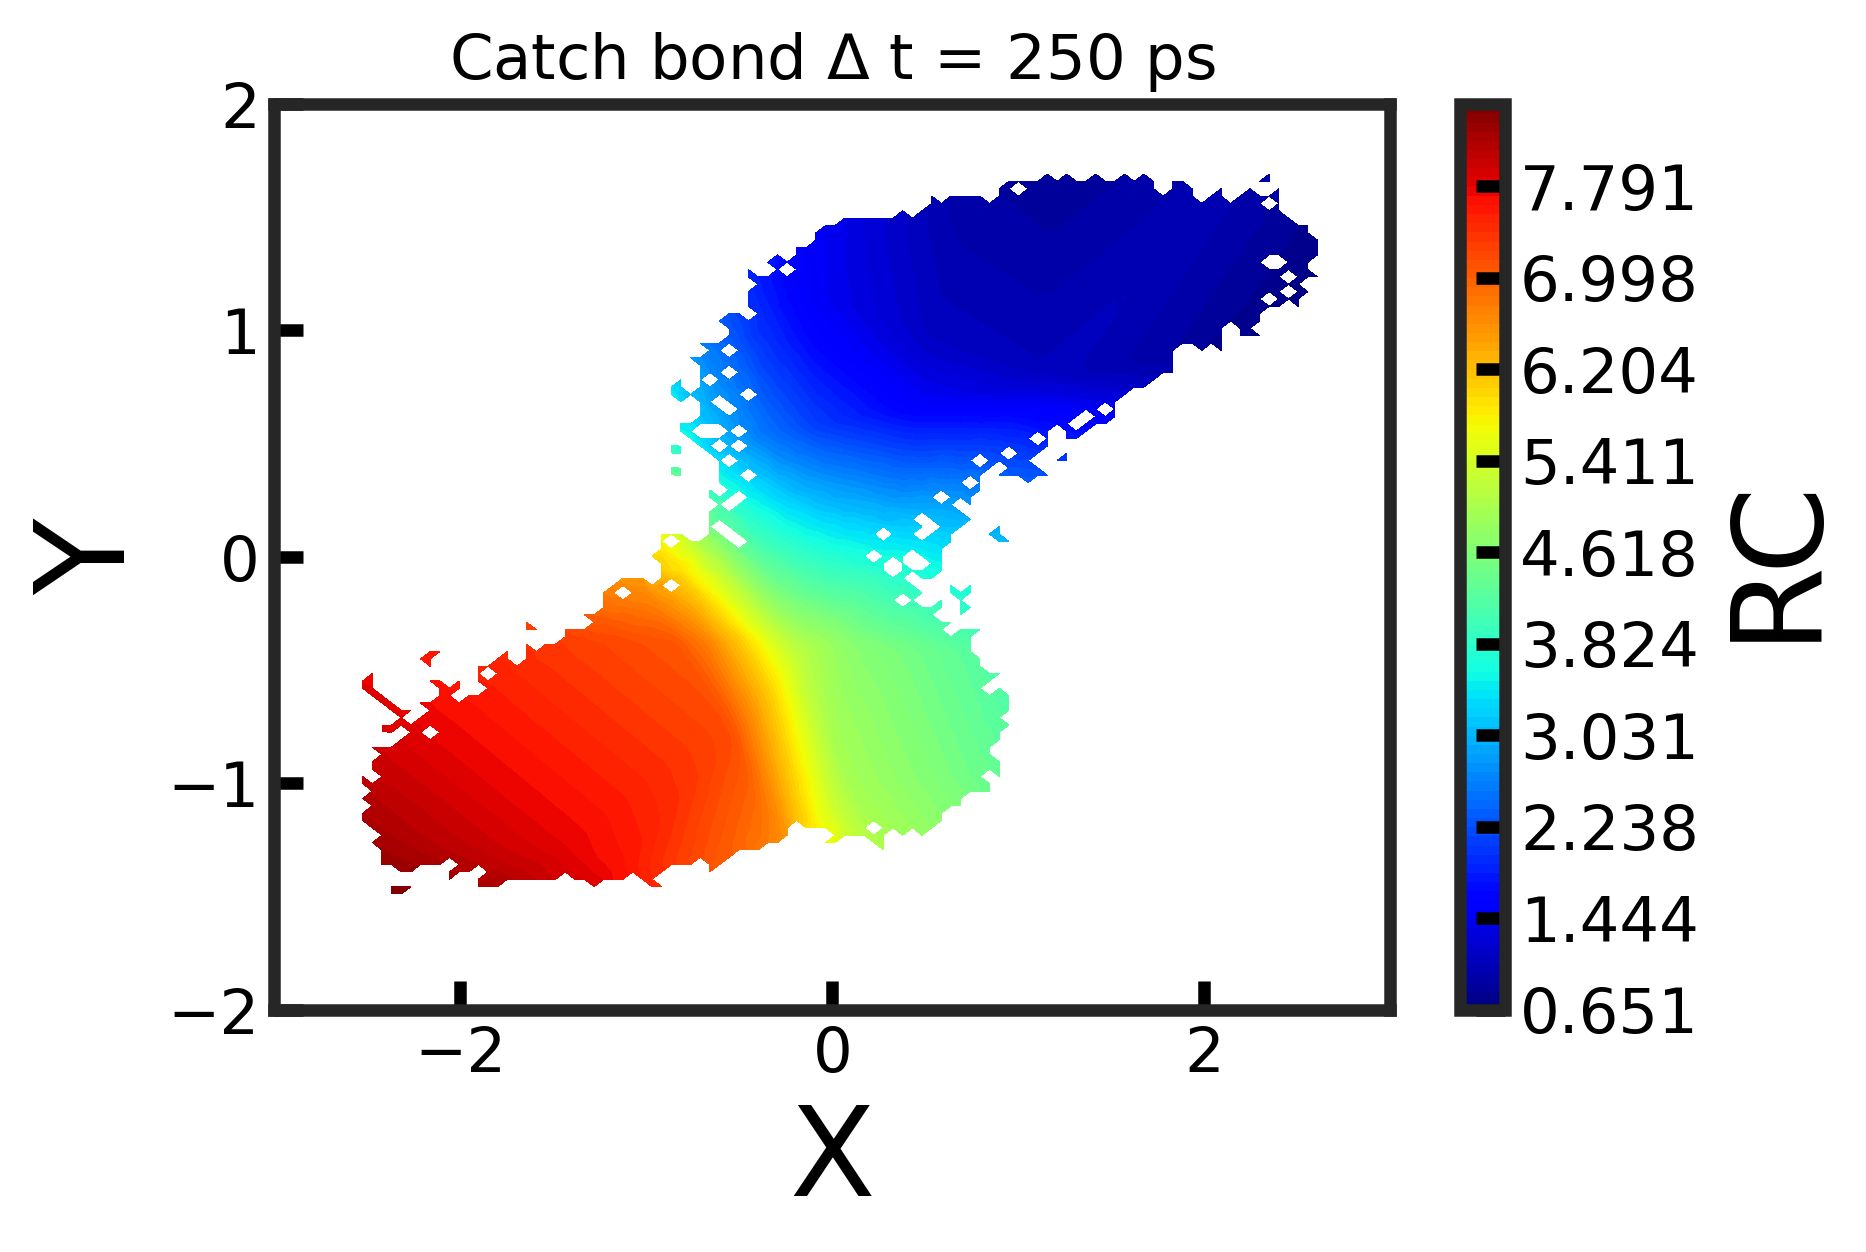

In [15]:
histdata,x,y = np.histogram2d(data[:,0],data[:,1],bins=100)
histMean,_,_ = np.histogram2d(data[:,0],data[:,1],bins=[x,y],weights=mean[:,0])
histRC = histMean/histdata
ax = plt.figure(dpi=300).add_subplot(111)

levels = np.linspace(mean[:,0].min(), mean[:,0].max(),100)
c = ax.contourf(x[:-1],y[:-1],histRC.T,cmap='jet',levels=levels)
cbar = plt.colorbar(c)
cbar.set_label("RC")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(-3,3)
ax.set_ylim(-2,2)
ax.set_title(r"Catch bond $\Delta$ t = {} ps".format(lagTime))

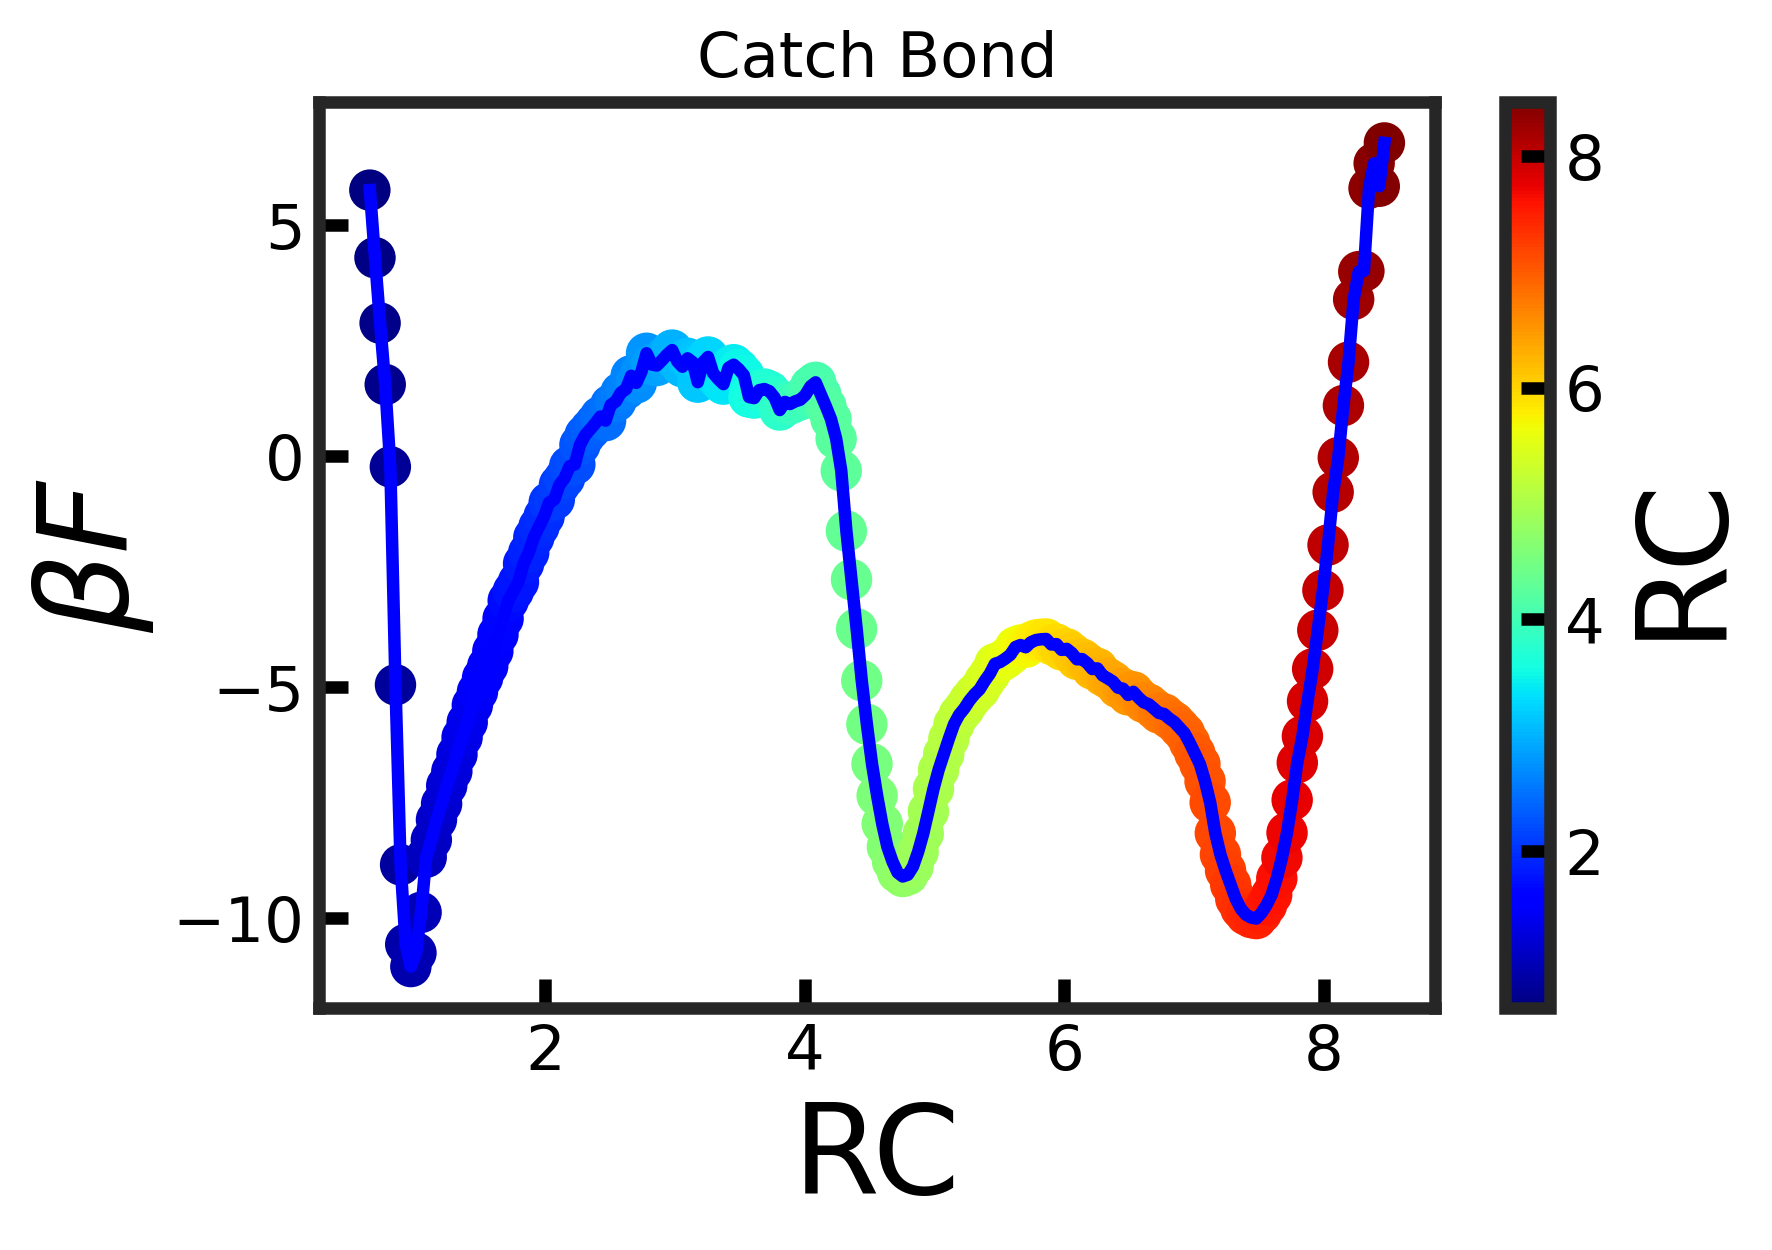

In [23]:
meanMin = mean.min() - 1e-3
meanMax = mean.max() + 1e-3
meanBin = np.linspace(meanMin, meanMax,200)
digitized = np.digitize(mean, meanBin).flatten()
int_ = []
for i in range(1,len(meanBin)):
    we = weights[digitized == i]
    int_.append(-logsumexp(-we))
ax = plt.figure(dpi=300).add_subplot(111)
ax.plot(meanBin[:-1],int_,c='b')
c = ax.scatter(meanBin[:-1],int_,c=meanBin[:-1],cmap='jet',s=80)
cbar = plt.colorbar(c)
ax.set_xlabel("RC")
ax.set_ylabel(r"$\beta F$")
ax.set_title("Catch Bond")
cbar.set_label("RC")

In [24]:
torch.save(v.state_dict(), "../model/CatchBond_4_25.pt")